# Exploratory Data Analysis - Box Office Datasets


## Business Understanding
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies.
<br>
You are charged with:
- Exploring what types of films are currently doing the best at the box office
- Translating the findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create


## Data Understanding
In the folder **`Data`** are movie Datasets:
<br>

| File Format | Source Info  |Contains|
|------|------|------|
|bom.movie_gross.csv |Box Office Mojo|Gross Information of Movies|
|rt.movie_info.tsv|Rotten Tomatoes|Movie Information|
|rt.reviews.tsv|Rotten Tomatoes|Movie Reviews  Information|
|tmdb.movies.csv|TheMovieDB|Movie Popularity Information|
|tn.movie_budgets.csv|The Numbers|Movies budget Information|
|im.db|IMDB|Movie Information as shown in the DataBase schema below|

Because it was collected from various locations, the different files have different formats as shown in the table above. Some are compressed CSV (comma-separated values) or TSV (tab-separated values) files that can be opened using spreadsheet software or pd.read_csv, while the data from IMDB is located in a SQLite database.

>_Below is the Database Schema of the IMDB database_
![movie_data_erd.jpeg](movie_data_erd.jpeg)


## Importing the required libraries for the EDA process

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# 1.[IMDB Dataset](https://www.imdb.com/)
***
## Data Preparation 
### Unzipping the `.zip` files
In the cells below we import the necessary libraries required for unzipping our data to access the SQLite DB

In [2]:
#importing the necessary libraries for unzipping
import glob
import zipfile

In [3]:
#Unzipping the .zip files for the IMDB
files = glob.glob('zippedData/*.zip')
files

['zippedData\\im.db.zip']

In [4]:
for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data/raw')

Unzipping: zippedData\im.db.zip


### Loading and Inspecting the database

In [5]:
#Importing the SQLite library and creating a database connection
import sqlite3
conn=sqlite3.connect('data/raw/im.db')

In [6]:
q1='''
SELECT *
FROM movie_basics
WHERE runtime_minutes IS NOT NULL'''
movies=pd.read_sql(q1,conn)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114405 entries, 0 to 114404
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         114405 non-null  object 
 1   primary_title    114405 non-null  object 
 2   original_title   114401 non-null  object 
 3   start_year       114405 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           112233 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ MB


# 2.[Box Office Mojo Dataset](https://www.boxofficemojo.com/)
***


## Loading and Inspecting the dataset

In [7]:
# Load the CSV files as a DataFrame
# Url path for our Datasets
grossBom_path='zippedData/bom.movie_gross.csv.gz'

#Coverting the zipped CSV files into a DataFrame
grossBom=pd.read_csv(grossBom_path, compression='gzip')
grossBom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [8]:
#feature selection
grossBom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [9]:
grossBom.shape

(3387, 5)

### Checking missing values
Based on our data we have significant missing values on the **foreign_gross** and a few missing values on **studio** and **domestic_gross** series respectively.<br>
We also need to convert our **foreign_gross** series from __object__ to __int64__

In [10]:
#checking for duplicates
grossBom.duplicated().any()

False

In [11]:
grossBom.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [12]:
#converting foreign_gross into int type
try:
    grossBom['foreign_gross']=grossBom['foreign_gross'].astype(float)
except Exception as error:
    print(error)

could not convert string to float: '1,131.6'


In [13]:
# Removing all special characters in the foreign_gross series 
grossBom['foreign_gross'].replace(',', '', inplace=True, regex=True)

#converting the foreign_gross series to float
grossBom['foreign_gross']=grossBom['foreign_gross'].astype(float)
grossBom['foreign_gross'].dtype

dtype('float64')

In [14]:
missing_domestic=round((grossBom['domestic_gross'].isna().sum()/len(grossBom))*100,2)
missing_foreign=round((grossBom['foreign_gross'].isna().sum()/len(grossBom))*100,2)
missing_studio=round((grossBom['studio'].isna().sum()/len(grossBom))*100,2)

print(f'Missing domestic_gross values percentage: {missing_domestic}% ')
print(f'Missing foreign_gross values percentage: {missing_foreign}%')
print(f'Missing studio names percentage: {missing_studio}%')

Missing domestic_gross values percentage: 0.83% 
Missing foreign_gross values percentage: 39.86%
Missing studio names percentage: 0.15%


### Dealing with missing values
Since the **missing studio names** and **domestic_gross** constitute 0.15% and 0.83% of our dataset, we'll have to drop the missing rows. 
<br>
The **missing foreign_gross** constitute 39.86% of our dataset. The **best approach would be to replace the missing/NAN values** by the mean of **foreign_gross**

In [15]:
#Dropping rows with missing values
grossBom.dropna(subset=['studio','domestic_gross'],axis=0,inplace=True)

#Replacing missing foreign_gross values with mean
mean_foreign=grossBom['foreign_gross'].mean()
grossBom['foreign_gross'].fillna(value=mean_foreign, axis=0,inplace=True)
grossBom.shape

(3356, 5)

In [16]:
#Rechecking our Dataset to see if it has missing values
grossBom.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

### Top 10 Box Office Movies that generated the highest foreign revenue

In [17]:
grossBom.sort_values(by='foreign_gross', ascending=False).head(10)

,title,studio,domestic_gross,foreign_gross,year
328,Harry Potter and the Deathly Hallows Part 2,WB,381000000.0,960500000.0,2011
1875,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015
727,Marvel's The Avengers,BV,623400000.0,895500000.0,2012
3081,Jurassic World: Fallen Kingdom,Uni.,417700000.0,891800000.0,2018
1127,Frozen,BV,400700000.0,875700000.0,2013
2764,Wolf Warrior 2,HC,2700000.0,867600000.0,2017
1477,Transformers: Age of Extinction,Par.,245400000.0,858600000.0,2014
1876,Minions,Uni.,336000000.0,823400000.0,2015
3083,Aquaman,WB,335100000.0,812700000.0,2018
1128,Iron Man 3,BV,409000000.0,805800000.0,2013


### Data Visualization
Trend of Gross sales over the past 10 years (2010-2018)

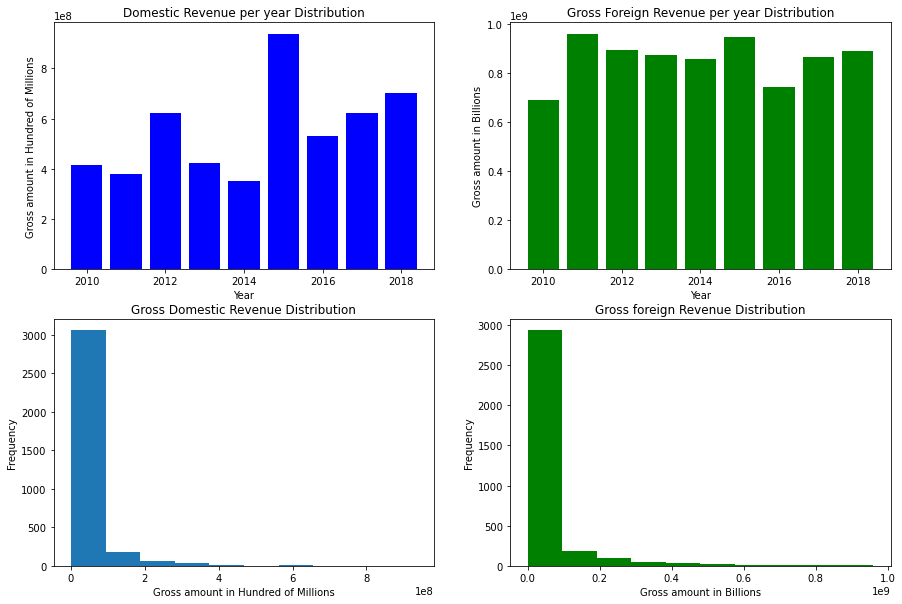

In [18]:
fig, ax=plt.subplots(figsize=(15,10),nrows=2,ncols=2)
x=grossBom['year']
y=grossBom['domestic_gross']
z=grossBom['foreign_gross']

# Domestic revenues over the years distribution
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Gross amount in Hundred of Millions')
ax[0,0].set_title('Domestic Revenue per year Distribution')
ax[0,0].bar(x,y,color='blue')

# Foreign revenue over the years distribution
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Gross amount in Billions')
ax[0,1].set_title('Gross Foreign Revenue per year Distribution')
ax[0,1].bar(x,z,color='green')

# Domestic Revenue Distribution
ax[1,0].set_xlabel('Gross amount in Hundred of Millions')
ax[1,0].set_title('Gross Domestic Revenue Distribution')
grossBom['domestic_gross'].plot(kind='hist',ax=ax[1,0])


# Gross Foreign Distribution
ax[1,1].set_xlabel('Gross amount in Billions')
ax[1,1].set_title('Gross foreign Revenue Distribution')
grossBom['foreign_gross'].plot(kind='hist',color='g',ax=ax[1,1]);

# 3.[The MovieDB Dataset](https://www.themoviedb.org/)
***

## Loading and Inspecting the dataset
It looks like this CSV came with an index column, resulting in an extra column called `Unnamed: 0` which we have to get rid off

In [19]:
# Url path for our Datasets
tmdb_path='zippedData/tmdb.movies.csv.gz'
tmdb=pd.read_csv(tmdb_path,index_col=0,compression='gzip')
tmdb.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [20]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


### Checking Duplicates 

In [21]:
#Checking duplicates
tmdb.duplicated(subset='original_title').value_counts()


False    24835
True      1682
dtype: int64

In [22]:
# Viewing rows that have duplicates
tmdb[tmdb.duplicated(subset=['genre_ids','id'])].head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
2473,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
2477,"[16, 35, 10751]",863,en,Toy Story 2,22.698,1999-11-24,Toy Story 2,7.5,7553
2536,"[12, 28, 878]",20526,en,TRON: Legacy,13.459,2010-12-10,TRON: Legacy,6.3,4387
2673,"[18, 10749]",46705,en,Blue Valentine,8.994,2010-12-29,Blue Valentine,6.9,1677
2717,"[35, 18, 14, 27, 9648]",45649,en,Rubber,8.319,2010-09-01,Rubber,5.9,417


In [23]:
tmdb.columns

Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [24]:
dups=tmdb.loc[tmdb['original_title'] == 'Boy']
dups.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
258,"[18, 35]",39356,en,Boy,7.759,2012-03-02,Boy,7.5,149
1037,"[35, 18, 10749]",44369,tl,Boy,1.504,2009-06-01,Boy,7.5,2
5404,"[18, 35]",39356,en,Boy,7.759,2012-03-02,Boy,7.5,149
12991,[18],321224,da,Boy,0.718,2014-06-20,Boy,6.0,4


### Observation and dealing with duplicates
Based on our Data we have established that a Movie can:
- Have same original_title
- Can belong to the same genre i.e have **same genre_ids**
<br>

To Identify a unique record we'll look at the **genre_ids, id and original_title**. Then we'll drop the duplicates based on this criteria 


In [25]:
tmdb = tmdb.drop_duplicates(subset = ['genre_ids', 'id','original_title']).reset_index(drop = True)
tmdb.duplicated().any()

False

### Dealing with Missing values

In [26]:
tmdb.shape

(25497, 9)

In [27]:
tmdb.isna().sum()

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

It seems that we have No missing values

In [28]:
#convert release_date data type to date
try:
    tmdb['release_date']=pd.to_datetime(tmdb['release_date'])
    tmdb['release_month']= tmdb['release_date'].dt.month_name()
    tmdb['release_year']= tmdb['release_date'].dt.year
except Exception as error:
    print(error)

In [29]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,release_year
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,March,2010
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,May,2010
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,November,1995
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,July,2010


<AxesSubplot:xlabel='release_month', ylabel='vote_count'>

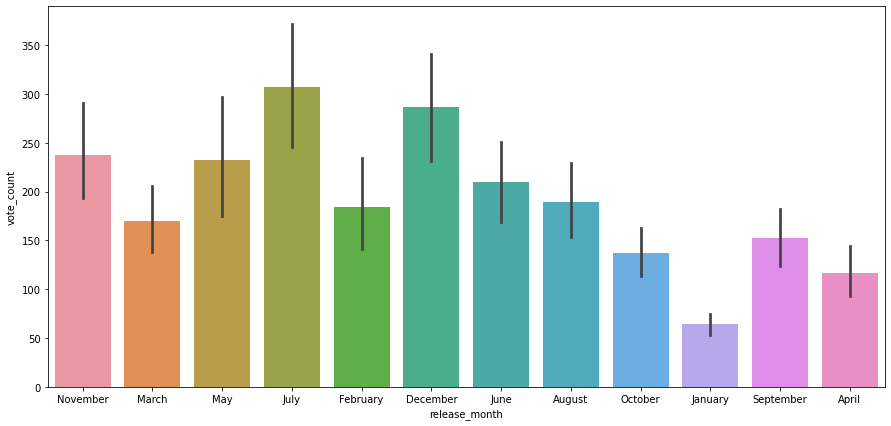

In [30]:
fig, ax=plt.subplots(figsize=(15,7))
sns.barplot(data=tmdb, y='vote_count', x='release_month')

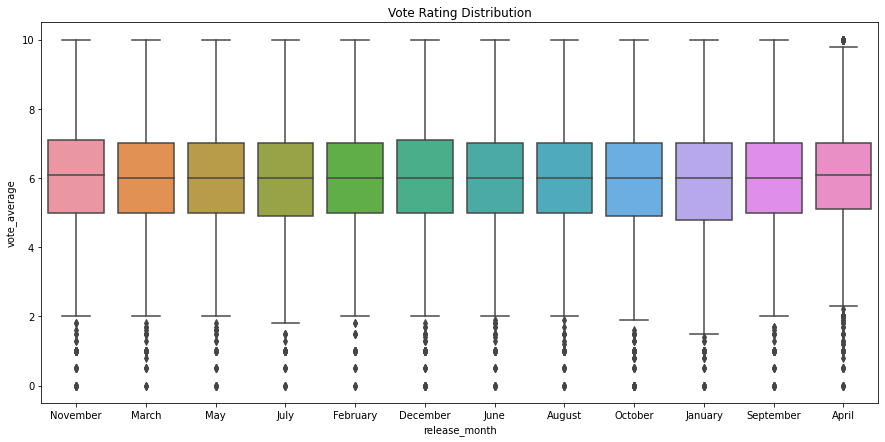

In [31]:
fig, ax=plt.subplots(figsize=(15,7))
ax.set_title('Vote Rating Distribution')
ax.set_xlabel('vote_average')

sns.boxplot(data=tmdb,x='release_month',y='vote_average');

In [32]:
#Mean and median of votes
tmdb['vote_average'].agg(['mean','median'])

mean      5.979331
median    6.000000
Name: vote_average, dtype: float64

In [33]:
#Top 10 Movie languages
tmdb['original_language'].value_counts().head(10)

en    22384
fr      483
es      439
ru      295
ja      244
de      231
zh      174
hi      171
it      119
pt       95
Name: original_language, dtype: int64

### Relationships between different features (correlation)

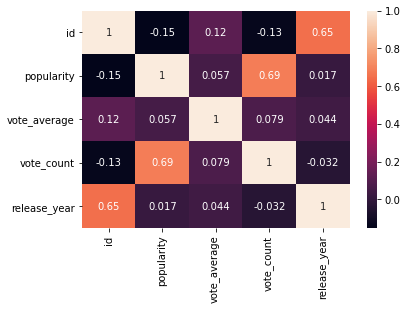

In [34]:
#Heatmap
ax = sns.heatmap(tmdb.corr(), annot=True)

Based on our Correlation analyis **popularity** and **vote_count** are highly correlated

In [35]:
tmdb['original_language'].value_counts()[:10]

en    22384
fr      483
es      439
ru      295
ja      244
de      231
zh      174
hi      171
it      119
pt       95
Name: original_language, dtype: int64

# 4.[The Numbers Dataset ](https://www.the-numbers.com/)
***

### Loading and Inspecting the dataset

In [36]:
# Url path for our Datasets
tnBudget_path='zippedData/tn.movie_budgets.csv.gz'
tnBudget=pd.read_csv(tnBudget_path,compression='gzip')
tnBudget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [37]:
tnBudget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Cleaning the Dataset
Based on the preview of the data we have no missing values but we have to remove special characters on production_budget,domestic_gross and worlwide_gross series

In [38]:
columns=['production_budget','domestic_gross','worldwide_gross']
for column in columns:
    # Removing ($ and ,) special characters in production_budget,domestic_gross and worldwide_gross
    tnBudget[column]=tnBudget[column].str.replace('[$,]', '')
    

tnBudget.head(2)   

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


In [39]:
#converting the Numerical values to type int
columns=['production_budget','domestic_gross','worldwide_gross']
for column in columns:
    tnBudget[column]=tnBudget[column].astype(float)

In [40]:
#Converting realease date to datetime dtype
tnBudget['release_date']=pd.to_datetime(tnBudget['release_date'], format= '%b %d, %Y')
#Creating a new month column
tnBudget['release_month']=tnBudget['release_date'].dt.month_name()
tnBudget['release_year']=tnBudget['release_date'].dt.year

In [41]:
tnBudget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 361.5+ KB


In [42]:
tnBudget.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,2003.967139
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,12.724386
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,1915.000000
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,2000.000000
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,2007.000000
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,2012.000000
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2020.000000


In [43]:
# Checking Duplicates
tnBudget.duplicated().any()

False

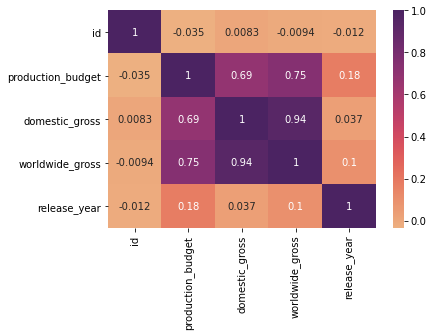

In [44]:
# Checking the Relationships of various features
fig, plt.plot(figsize=(15,5))
color=sns.color_palette('flare', as_cmap=True)
correlation=tnBudget.corr()
sns.heatmap(correlation, annot=True,cmap=color);

### Tip
Show the Relationship of  production budget vs domestic & worldwide_gross based on year or month

# 5.[Rotten Tomatoes Dataset](https://www.rottentomatoes.com/)
***

### Loading and Inspecting the dataset

In [45]:
#Load the Rotten Tomatoes TSV files as a DataFrame
rt_movie_path='zippedData/rt.movie_info.tsv.gz'
rt_reviews_path='zippedData/rt.reviews.tsv.gz'

#converting all the zipped TSV files into a DataFrame
rt_movies=pd.read_csv(rt_movie_path,delimiter='\t',encoding='latin1',compression='gzip')
rt_reviews=pd.read_csv(rt_reviews_path,delimiter='\t',encoding='latin1',compression='gzip')

#Preview of the Rotten tomatoes movies dataset
rt_movies.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


### Tip
Use the runtime, theater date, genre,rating, writer,director,Rating and box_office features

In [46]:
#Preview of the Rotten tomatoes reviews dataset
rt_reviews.head(2)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"


In [47]:
#Renaming our date to establish
rt_reviews.columns = rt_reviews.columns.str.replace('date', 'review_date')

In [48]:
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,review_date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [49]:
#Merge the two dataframes
#rt_merge=pd.merge(rt_movies, rt_reviews, on='id')
#rt_merge.head(2)

In [50]:
rt_reviews[rt_reviews.duplicated(subset='id')]

,id,review,rating,fresh,critic,top_critic,publisher,review_date
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
5,3,... Cronenberg's Cosmopolis expresses somethin...,NaN,fresh,Michelle Orange,0,Capital New York,"September 11, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"
